Importing Library for the prgramming

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 12)

Populating the interactive namespace from numpy and matplotlib


Now, reading the file "new data". As the file doesnt contain data-time format, joining the data and time columns and converting it to data-time format and removing the unnecessary columns.

In [27]:
dataframe = pd.read_csv("C:/Users/vipinkmr0808/Desktop/NEW-DATA-1.csv",sep=' ')
dataframe["date-time"] = pd.to_datetime(dataframe['1:Date'] + ' ' + dataframe['2:Time'])
dataframe.index = dataframe["date-time"] 
dataframe = dataframe.drop(['1:Date','2:Time',"date-time"],axis=1)

For better understanding of the dependency of target and features, renaming all the variable parameters into english.

In [28]:
dataframe.rename(columns={'3:Temperature_Comedor_Sensor':'diningroom_temp',
                    '4:Temperature_Habitacion_Sensor':'room_temp',
                    '5:Weather_Temperature':'weather_temp',
                    '6:CO2_Comedor_Sensor':'co2_dining',
                    '7:CO2_Habitacion_Sensor':'co2_room',
                    '8:Humedad_Comedor_Sensor':'humid_dining',
                    '9:Humedad_Habitacion_Sensor':'humid_room',
                    '10:Lighting_Comedor_Sensor':'lighting_dining',
                    '11:Lighting_Habitacion_Sensor':'lighting_room', 
                    '18:Meteo_Exterior_Piranometro':'Sun irradiance',
                    '22:Temperature_Exterior_Sensor':'Outdoor temperature'}, inplace=True)

Creating time related features.

In [29]:
dataframe['hour'] = dataframe.index.hour
dataframe['day_of_week'] = dataframe.index.dayofweek

#dataframe['weekend'] = np.where(((dataframe['day_of_week']==5) or (dataframe['day_of_week']==6)), 1, 0)
dataframe['day_night'] = np.where((dataframe['hour']>=10)&(dataframe['hour']<=19), 1, 0)

def weekend_detector(day):
    if (day==5 or day==6):
        weekend = 1
    else:
        weekend = 0
    return weekend


dataframe['weekend'] = [weekend_detector(s) for s in dataframe['day_of_week']]


For a better observation of wide range of data on the graph plots, we normalize the data

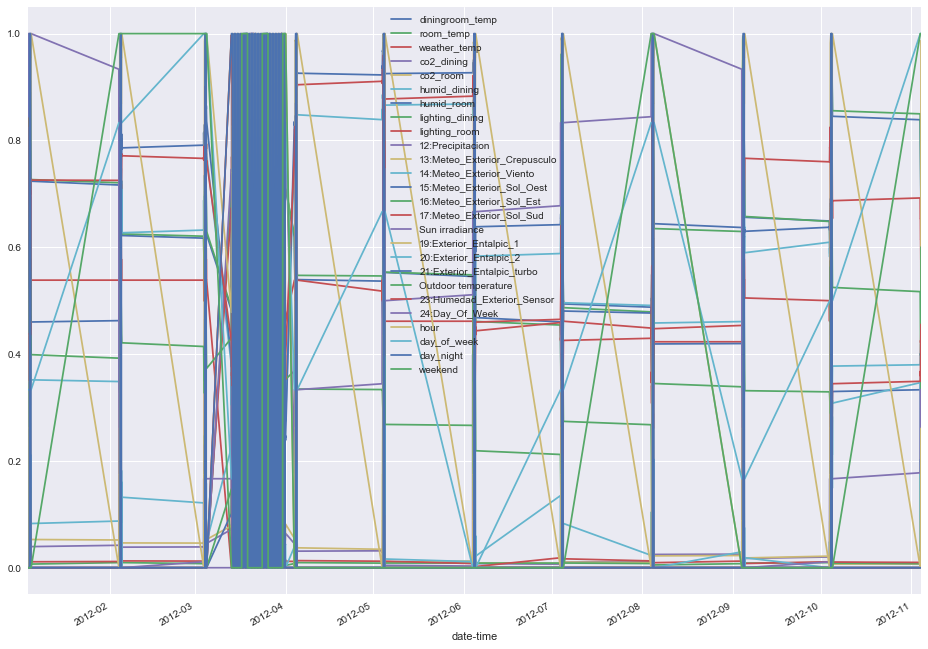

In [30]:
def normalize(df):
    return (df - df.min())/(df.max()-df.min())
normalize(dataframe).plot()

This data base contains data only for the month of march and therefore we narrow our dataframe.

In [31]:
dataframe = dataframe["2012-03-10":"2012-04-01"]

In [32]:
dataframe.columns

Index([u'diningroom_temp', u'room_temp', u'weather_temp', u'co2_dining',
       u'co2_room', u'humid_dining', u'humid_room', u'lighting_dining',
       u'lighting_room', u'12:Precipitacion', u'13:Meteo_Exterior_Crepusculo',
       u'14:Meteo_Exterior_Viento', u'15:Meteo_Exterior_Sol_Oest',
       u'16:Meteo_Exterior_Sol_Est', u'17:Meteo_Exterior_Sol_Sud',
       u'Sun irradiance', u'19:Exterior_Entalpic_1', u'20:Exterior_Entalpic_2',
       u'21:Exterior_Entalpic_turbo', u'Outdoor temperature',
       u'23:Humedad_Exterior_Sensor', u'24:Day_Of_Week', u'hour',
       u'day_of_week', u'day_night', u'weekend'],
      dtype='object')

Since, some parameters doesnt have any influence over the target, we drop those parameters.

In [33]:
dataframe=dataframe.drop(['12:Precipitacion','13:Meteo_Exterior_Crepusculo',
       '14:Meteo_Exterior_Viento', '15:Meteo_Exterior_Sol_Oest',
       '16:Meteo_Exterior_Sol_Est', '17:Meteo_Exterior_Sol_Sud',
       '19:Exterior_Entalpic_1', '20:Exterior_Entalpic_2',
       '21:Exterior_Entalpic_turbo', 
       '23:Humedad_Exterior_Sensor', '24:Day_Of_Week'],axis=1)


Plotting normalized data of "room temp"'"Irradiance" and "Outdoor temp" for the month of "March"

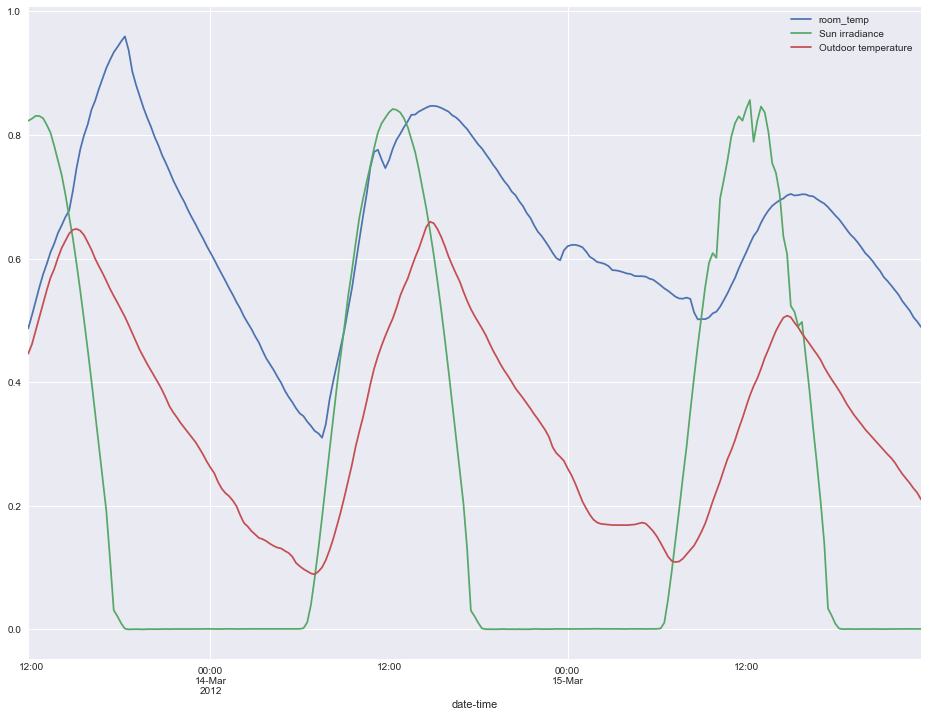

In [34]:
normalize(dataframe)[["room_temp","Sun irradiance","Outdoor temperature"]]["2012-03-10":"2012-03-15"].plot()

Defining function to create lagging.

In [35]:
def lag_column(df,column_names,lag_times=1):
 
    for column_name in column_names:
        column_name = str(column_name)
        for i in np.arange(1,lag_times+1,1):
            new_column_name = column_name+'_'+str(i)+'_x 15 min'
            df[new_column_name]=(df[column_name]).shift(i)
    return df

Creating a new dataframe "df_lagged" after lagging the desired features

In [36]:
df_lagged = lag_column(dataframe,['Sun irradiance','Outdoor temperature','room_temp'],lag_times=16)

Dropping the NaN values in the df_lagged dataframe 

In [37]:
df_lagged.dropna(inplace=True)

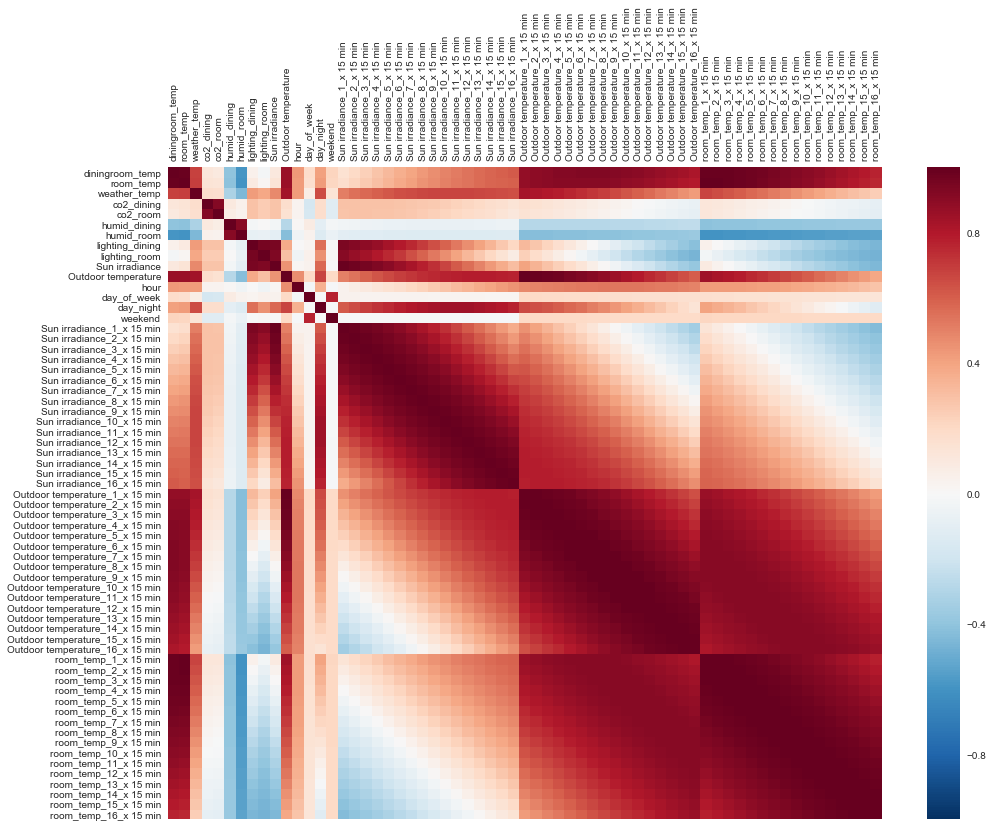

In [38]:
import seaborn as sns
fig = plt.figure()
plot = fig.add_axes()
plot = sns.heatmap(df_lagged.dropna().corr(), annot=False)
plot.xaxis.tick_top() 
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

Defining target and features.

In [39]:
target = dataframe[['room_temp']]

features = dataframe[[s for s in dataframe.columns if "room_temp" != s]]


Importing Sklearn library for testing and traning the data. Considering 80% of the data as training and 20% as testing.

In [40]:
from sklearn.model_selection import train_test_split

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=123524)


Initially using linear regression to predict our target and naming our prediction as prediction room temp. then creating a new dataframe "Joined" after joining prediction with target.

In [41]:
from sklearn import linear_model
linear_reg = linear_model.LinearRegression()

linear_reg.fit(features_train,target_train)

prediction = linear_reg.predict(features_test)
### converting into pandas series  and naming it as  Prediction room_temp
predict_series = pd.Series(prediction.ravel(),index=target_test.index).rename('Prediction room_temp')
joined = pd.DataFrame(predict_series).join(target_test)


Initially using linear regression to predict our target and naming our prediction as prediction room temp. then creating a new dataframe "Joined" after joining prediction with target.

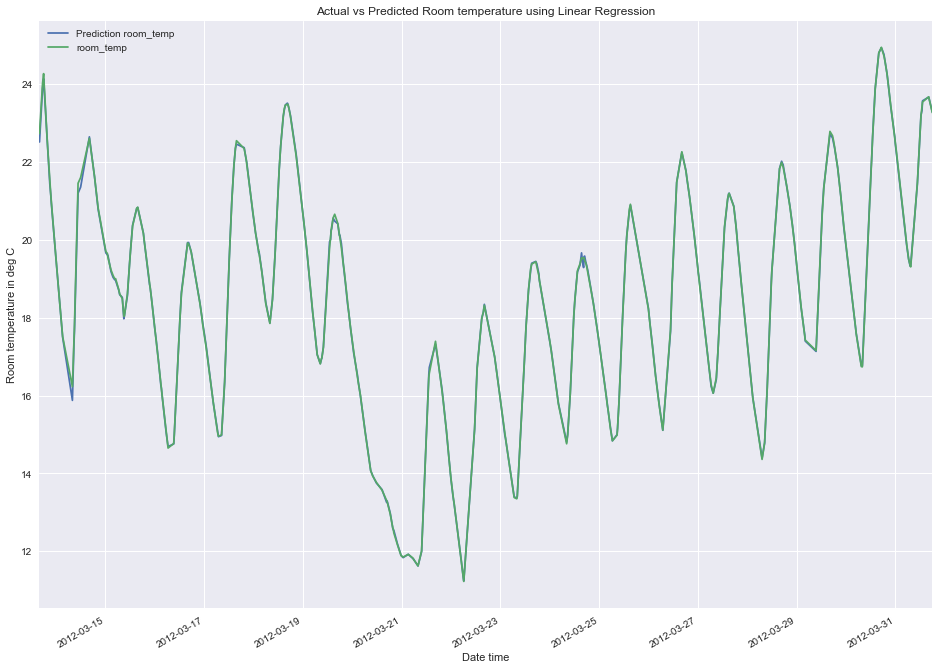

In [42]:
joined.plot()
plt.xlabel("Date time")
plt.ylabel("Room temperature in deg C")
plt.title("Actual vs Predicted Room temperature using Linear Regression")

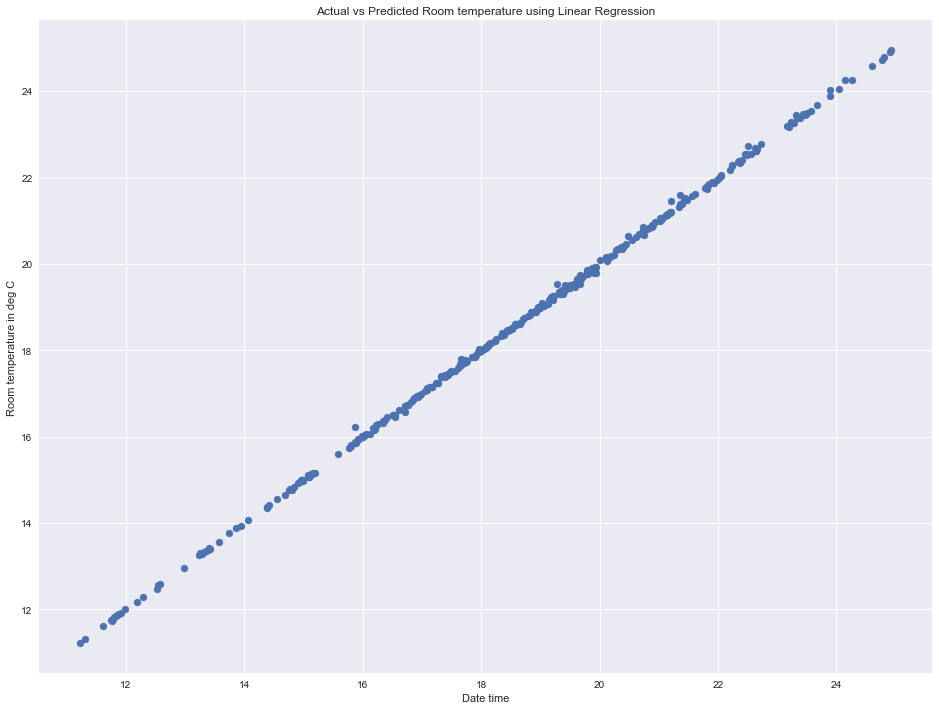

In [43]:
plt.scatter(joined["Prediction room_temp"],joined["room_temp"])
plt.xlabel("Date time")
plt.ylabel("Room temperature in deg C")
plt.title("Actual vs Predicted Room temperature using Linear Regression")
plt.show()

In [44]:
from sklearn.metrics import r2_score

r2_linear = r2_score(joined["Prediction room_temp"],joined["room_temp"])
print r2_linear

0.999734806957


Using random forest regression to cross check our prediction and target results.

In [45]:
from sklearn.ensemble import RandomForestRegressor
random_reg = RandomForestRegressor()

random_reg.fit(features_train,target_train)

prediction_rand = random_reg.predict(features_test)

predict_series_rand = pd.Series(prediction_rand.ravel(),index=target_test.index).rename('Prediction room_temp')
joined_rand = pd.DataFrame(predict_series_rand).join(target_test)

C:\Users\vipinkmr0808\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


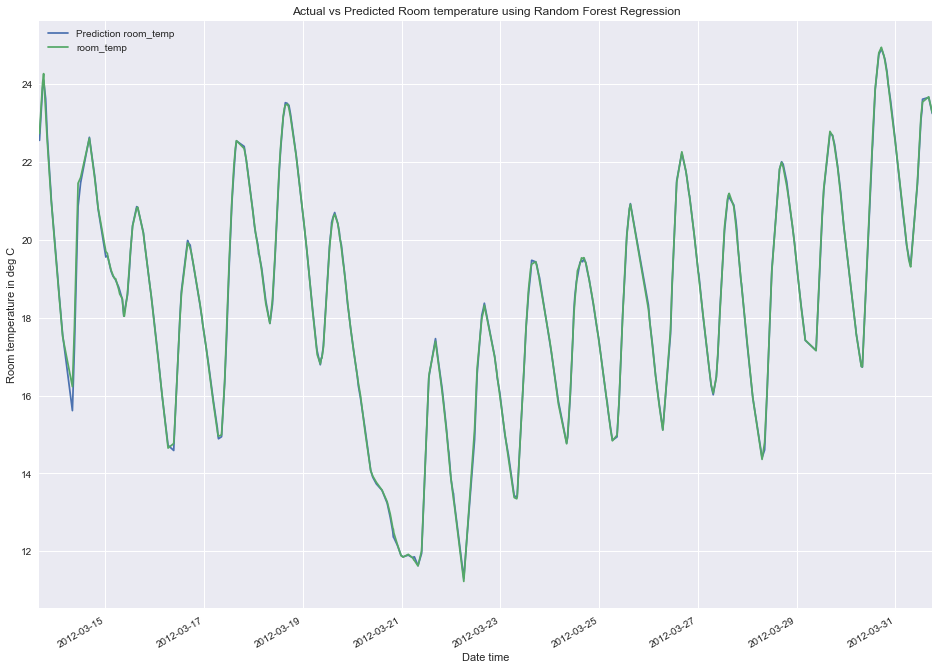

In [46]:
joined_rand.plot()
plt.xlabel("Date time")
plt.ylabel("Room temperature in deg C")
plt.title("Actual vs Predicted Room temperature using Random Forest Regression")

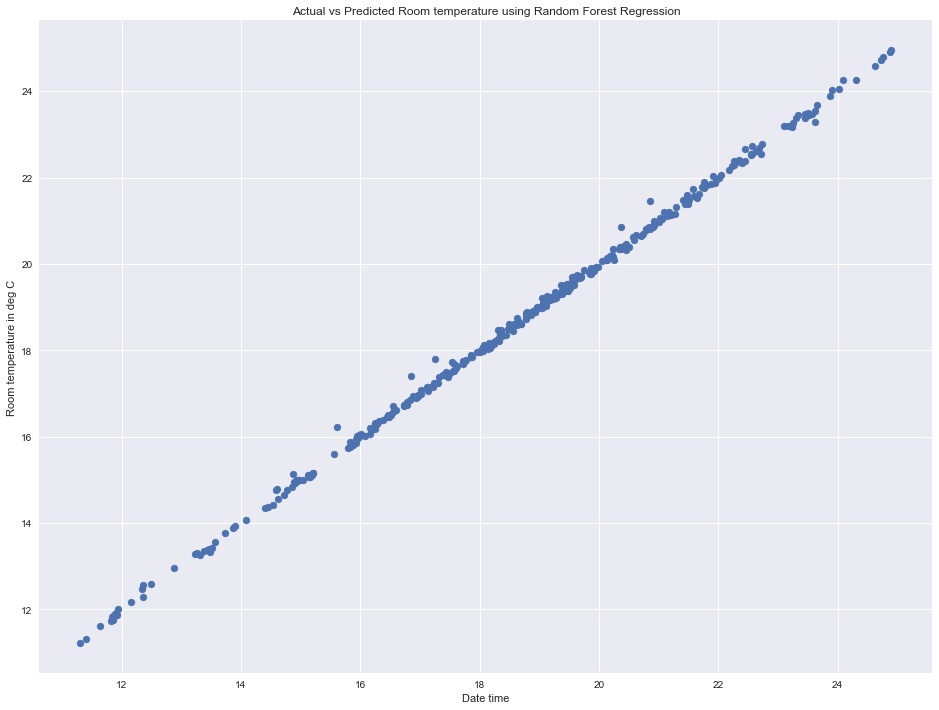

In [47]:
plt.scatter(joined_rand["Prediction room_temp"],joined_rand["room_temp"])
plt.xlabel("Date time")
plt.ylabel("Room temperature in deg C")
plt.title("Actual vs Predicted Room temperature using Random Forest Regression")
plt.show()

In [48]:
from sklearn.metrics import r2_score

r2_linear = r2_score(joined_rand["Prediction room_temp"],joined_rand["room_temp"])
print r2_linear

0.998970081383


R^2 values------- Using linear regression = 99.97
          ------- Using random forest regression = 99.90

Comments:The coefficient of determination  between target and set of features  discussed in this script is quiet satisfactory using both linear regression and random forest regression.